<a href="https://colab.research.google.com/github/semthedev/data-analytics-projects/blob/main/a_b_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# А/В-тест для оптимизации лендингов в E-Commerce

## Данные:
https://www.kaggle.com/datasets/zhangluyuan/ab-testing

**А/В-эксперимент**

Компания тестирует новую версию лендинг-страницы с целью увеличить количество пользователей, совершающих целевое действие - то есть повысить коэффициент конверсии.

Пользователи случайным образом направляются на одну из двух версий:

Старая версия страницы (контрольная группа - control),

Новая версия страницы (тестовая группа - treatment).

Цель эксперимента - определить, приводит ли новая страница к статистически значимому росту конверсий.

**Формулировка гипотез**

Нулевая гипотеза (H0):
Новая страница не влияет на конверсию.
P_new = P_old
(где P — вероятность конверсии)

Альтернативная гипотеза (H1):
Новая страница влияет на конверсию.
То есть:
P_new ≠ P_old

## 1. Загрузка данных и их предобработка

In [10]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
%matplotlib inline

In [11]:
df = pd.read_csv('ab_data.csv')
df.head()


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [18]:
df.duplicated().sum()

np.int64(0)

дубликатов нет

In [13]:
df['group'].unique()

array(['control', 'treatment'], dtype=object)

In [14]:
df['landing_page'].unique()

array(['old_page', 'new_page'], dtype=object)

In [15]:
df['landing_page'].unique()

array(['old_page', 'new_page'], dtype=object)

In [21]:
duplicates = df.duplicated(subset=['user_id'], keep=False)
print(df[duplicates].sort_values(by='user_id'))

        user_id                   timestamp      group landing_page  converted
213114   630052  2017-01-07 12:25:54.089486  treatment     old_page          1
230259   630052  2017-01-17 01:16:05.208766  treatment     new_page          0
251762   630126  2017-01-19 17:16:00.280440  treatment     new_page          0
22513    630126  2017-01-14 13:35:54.778695  treatment     old_page          0
11792    630137  2017-01-22 14:59:22.051308    control     new_page          0
...         ...                         ...        ...          ...        ...
99479    945703  2017-01-18 06:39:31.294688    control     old_page          0
186960   945797  2017-01-13 17:23:21.750962    control     old_page          0
40370    945797  2017-01-11 03:04:49.433736    control     new_page          1
165143   945971  2017-01-16 10:09:18.383183    control     old_page          0
131756   945971  2017-01-22 12:43:54.087275    control     new_page          0

[7788 rows x 5 columns]


Обнаружили дубликаты в user_id. Избавляемся от них.


In [22]:
df_unique = df.drop_duplicates(subset=['user_id'])
duplicates = df_unique.duplicated(subset=['user_id'], keep=False)
print(df_unique[duplicates].sort_values(by='user_id'))

Empty DataFrame
Columns: [user_id, timestamp, group, landing_page, converted]
Index: []


In [24]:
df_unique.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290584 non-null  int64 
 1   timestamp     290584 non-null  object
 2   group         290584 non-null  object
 3   landing_page  290584 non-null  object
 4   converted     290584 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [27]:
df_unique.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [28]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


проверяем пропущенные значения

In [29]:
df.isnull().sum()

,0
user_id,0
timestamp,0
group,0
landing_page,0
converted,0


In [31]:
df_clean = df_unique[
    ((df_unique['group'] == 'control') & (df_unique['landing_page'] == 'old_page')) |
    ((df_unique['group'] == 'treatment') & (df_unique['landing_page'] == 'new_page'))
]


In [32]:
df_clean['group'].value_counts()


,count
group,
treatment,144314
control,144226


## Определение размера выборки

In [34]:
# Расчитываем размера выборки
effect_size = sms.proportion_effectsize(0.12, 0.14)
# Здесь мы предполагаем что текущая конверсия = 0.12, а целевая = 0.14

# Расчёт необходимого размера выборки для A/B теста
required_sample = sms.NormalIndPower().solve_power(
    effect_size,
    power=0.8,
    alpha=0.05,
    ratio=1
)

required_sample = ceil(required_sample)

print("Необходимое количество наблюдений в каждой группе:", required_sample)

Необходимое количество наблюдений в каждой группе: 4433


In [35]:
# Сэмплируем по 4433 уникальных пользователей из группы control и treatment

control_new = df_unique[df_unique['group'] == 'control'].sample(n=required_sample, random_state=7)
treatment_new = df_unique[df_unique['group'] == 'treatment'].sample(n=required_sample, random_state=7)

ab_test = pd.concat([control_new, treatment_new], axis=0)
ab_test.reset_index(drop=True, inplace=True)

ab_test

,user_id,timestamp,group,landing_page,converted
0,778243,2017-01-19 16:14:26.292281,control,old_page,0
1,843034,2017-01-22 00:03:12.061165,control,old_page,0
2,936218,2017-01-12 18:16:10.518334,control,old_page,0
3,929296,2017-01-11 22:26:43.161061,control,old_page,1
4,814775,2017-01-03 23:01:57.969597,control,old_page,0
...,...,...,...,...,...
8861,832753,2017-01-16 23:47:55.837432,treatment,new_page,0
8862,746946,2017-01-21 17:17:04.868867,treatment,new_page,0
8863,643301,2017-01-20 02:44:25.880400,treatment,new_page,0
8864,944265,2017-01-20 15:29:45.141502,treatment,new_page,0


In [36]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8866 entries, 0 to 8865
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       8866 non-null   int64 
 1   timestamp     8866 non-null   object
 2   group         8866 non-null   object
 3   landing_page  8866 non-null   object
 4   converted     8866 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 346.5+ KB


In [37]:
ab_test['group'].value_counts()

,count
group,
control,4433
treatment,4433


In [38]:
ab_test['landing_page'].value_counts()

,count
landing_page,
new_page,4438
old_page,4428


## Исследовательский анализ

In [51]:
conversion_rates = ab_test.groupby('group')['converted']

# std. deviation
std_p = lambda x: np.std(x)

# std. error
se_p = lambda x: stats.sem(x)

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates

/tmp/ipython-input-2053039511.py:9: FutureWarning: The provided callable <function mean at 0x78283fd90220> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])


,conversion_rate,std_deviation,std_error
group,,,
control,0.124295,0.329918,0.004956
treatment,0.110986,0.314115,0.004718


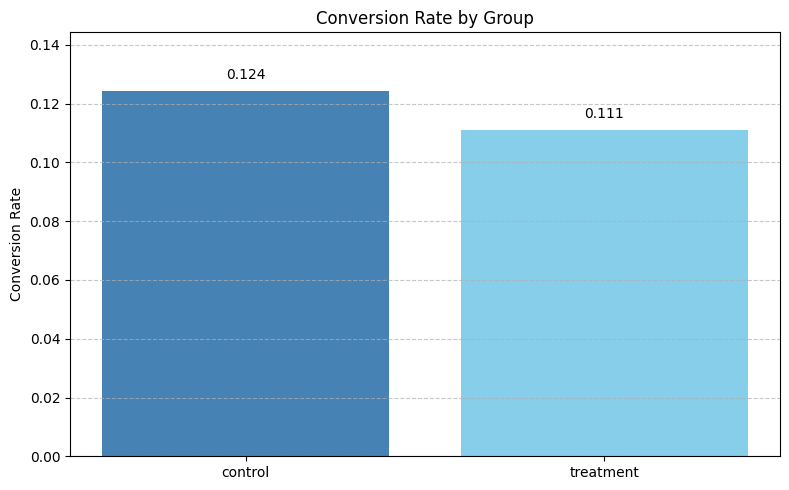

In [57]:
import matplotlib.pyplot as plt

# Извлекаем значения и индексы из готовой таблицы
group_names = conversion_rates.index.tolist()
conversion_rates_vals = conversion_rates['conversion_rate'].tolist()

# Построение вертикального barplot
plt.figure(figsize=(8, 5))
bars = plt.bar(group_names, conversion_rates_vals, color=['steelblue', 'skyblue'])

# Добавляем подписи над столбцами
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.003, f'{yval:.3f}', ha='center', va='bottom')

# Настройки
plt.title('Conversion Rate by Group')
plt.ylabel('Conversion Rate')
plt.ylim(0, max(conversion_rates_vals) + 0.02)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Статистическая проверка гипотез

In [60]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# Выбираем только значения конверсий для контрольной, тестовой группы
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

# Получаем объем выборки для каждой группы
n_con = control_results.count()
n_treat = treatment_results.count()

# Cчитаем количество конверсий,
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]
# Объем выборки для обеих групп

# Расчет z-статистики и p-value (проверка значимости разницы)
z_stat, pval = proportions_ztest(successes, nobs=nobs)

# Расчет 95% доверительных интервалов для долей конверсий
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.3f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 1.945
p-value: 0.052
ci 95% for control group: [0.115, 0.134]
ci 95% for treatment group: [0.102, 0.120]


## Выводы:

Конверсия в контрольной группе составила 12.43%, в то время как в тестовой группе 11.10%.

Полученное значение z-статистики: 1.94, что ниже критического порога 1.96 при уровне значимости 0.05. Это означает, что нельзя утверждать, что между двумя версиями страниц есть значимая разница.

Значение p-value (0.052) превышает пороговое значение 0.05, что не даёт достаточных оснований для отклонения нулевой гипотезы.

Доверительный интервал (95%) для контрольной группы показывает, что реальная конверсия, с высокой вероятностью, находится в диапазоне от 11.5% до 13.4%.

Для тестовой группы 95% доверительный интервал не включает целевую конверсию 14%, что говорит о недостижении желаемого эффекта от новой страницы.

В совокупности, результаты A/B тестирования не указывают на существенное улучшение метрики конверсии после внедрения новой версии страницы, поэтому наилучшим решением будет сохранить текущий (старый) вариант.